In [1]:
import os
import random
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn import metrics

# Reproducibility 

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Device Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Loading

## Transform and load dataset

In [4]:
transform = transforms.ToTensor()
data_root = os.getcwd()

train_data = MNIST(root=data_root, train=True,  transform=transform, download=True)
test_data  = MNIST(root=data_root, train=False, transform=transform, download=True)

## Data loaders

In [5]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)

# Optional preview

In [6]:
transforms.ToPILImage()(train_data[0][0])

# Model Definition


In [7]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 250),
            nn.ReLU(),
            nn.Linear(250, 150),
            nn.ReLU(),
            nn.Linear(150, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)

model = MNISTClassifier().to(device)

# Loss & Optimizer


In [8]:
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Training loop


In [9]:
epochs = 100
train_losses = []
val_losses   = []

for epoch in range(1, epochs+1):
    model.train()
    total_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss    = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)

    avg_train = total_train_loss / len(train_data)
    train_losses.append(avg_train)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss    = loss_fn(outputs, labels)
            total_val_loss += loss.item() * images.size(0)

    avg_val = total_val_loss / len(test_data)
    val_losses.append(avg_val)

    print(f"Epoch {epoch}/{epochs} "
          f"| Train Loss: {avg_train:.4f} "
          f"| Val Loss: {avg_val:.4f}")


Epoch 1/100 | Train Loss: 1.7608 | Val Loss: 0.8082
Epoch 2/100 | Train Loss: 0.5665 | Val Loss: 0.4286
Epoch 3/100 | Train Loss: 0.3985 | Val Loss: 0.3501
Epoch 4/100 | Train Loss: 0.3462 | Val Loss: 0.3133
Epoch 5/100 | Train Loss: 0.3160 | Val Loss: 0.2908
Epoch 6/100 | Train Loss: 0.2934 | Val Loss: 0.2780
Epoch 7/100 | Train Loss: 0.2750 | Val Loss: 0.2583
Epoch 8/100 | Train Loss: 0.2582 | Val Loss: 0.2445
Epoch 9/100 | Train Loss: 0.2434 | Val Loss: 0.2302
Epoch 10/100 | Train Loss: 0.2296 | Val Loss: 0.2180
Epoch 11/100 | Train Loss: 0.2168 | Val Loss: 0.2080
Epoch 12/100 | Train Loss: 0.2055 | Val Loss: 0.1999
Epoch 13/100 | Train Loss: 0.1948 | Val Loss: 0.1909
Epoch 14/100 | Train Loss: 0.1853 | Val Loss: 0.1812
Epoch 15/100 | Train Loss: 0.1764 | Val Loss: 0.1730
Epoch 16/100 | Train Loss: 0.1682 | Val Loss: 0.1673
Epoch 17/100 | Train Loss: 0.1605 | Val Loss: 0.1614
Epoch 18/100 | Train Loss: 0.1536 | Val Loss: 0.1547
Epoch 19/100 | Train Loss: 0.1467 | Val Loss: 0.1495
Ep

# Plot losses


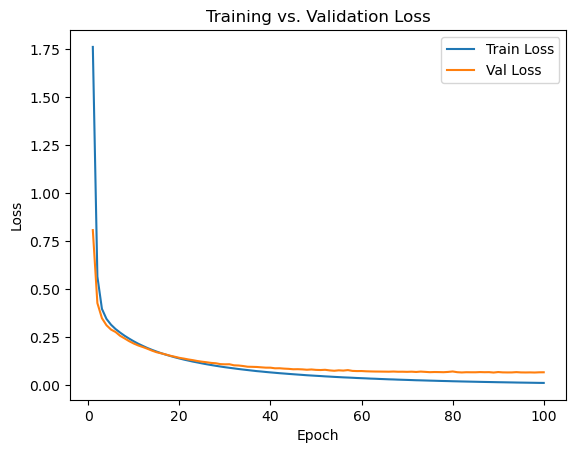

In [10]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses,   label='Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation & Metrics


In [11]:
model.eval()
all_preds  = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report
classes = train_data.classes
print("Classification Report:\n")
print(metrics.classification_report(
    all_labels, all_preds, target_names=classes, zero_division=0
))

Classification Report:

              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.98       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.97      0.98      0.98      1032
   3 - three       0.98      0.98      0.98      1010
    4 - four       0.98      0.98      0.98       982
    5 - five       0.98      0.98      0.98       892
     6 - six       0.98      0.98      0.98       958
   7 - seven       0.98      0.98      0.98      1028
   8 - eight       0.97      0.97      0.97       974
    9 - nine       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# Confusion Matrix


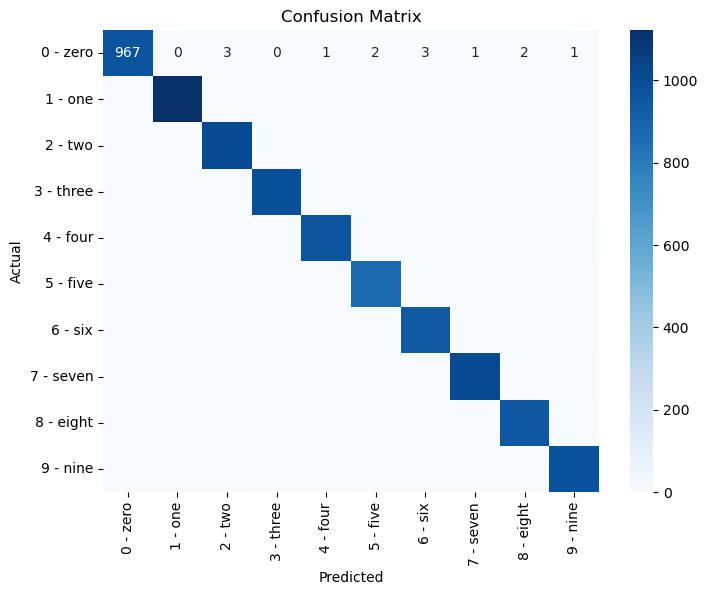

In [12]:
# Confusion matrix
cm = metrics.confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(8,6))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report


In [13]:
print(metrics.classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.98       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.97      0.98      0.98      1032
   3 - three       0.98      0.98      0.98      1010
    4 - four       0.98      0.98      0.98       982
    5 - five       0.98      0.98      0.98       892
     6 - six       0.98      0.98      0.98       958
   7 - seven       0.98      0.98      0.98      1028
   8 - eight       0.97      0.97      0.97       974
    9 - nine       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

